In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 wh

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from transformers import pipeline
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import time
import torch

In [4]:
class TOPSIS:
    def __init__(self, weights, criteria):
        self.weights = np.array(weights)
        self.criteria = np.array(criteria)
        self.scaler = MinMaxScaler()

    def fit_transform(self, data):
        normalized_data = self.scaler.fit_transform(data) * self.weights
        ideal_best = np.max(normalized_data, axis=0) * self.criteria + np.min(normalized_data, axis=0) * (1 - self.criteria)
        ideal_worst = np.min(normalized_data, axis=0) * self.criteria + np.max(normalized_data, axis=0) * (1 - self.criteria)

        distance_best = np.linalg.norm(normalized_data - ideal_best, axis=1)
        distance_worst = np.linalg.norm(normalized_data - ideal_worst, axis=1)

        return distance_worst / (distance_best + distance_worst)

In [5]:
def load_models():
    return {
        "DistilBERT": pipeline("text-classification", model="distilbert-base-uncased-finetuned-sst-2-english"),
        "RoBERTa": pipeline("text-classification", model="roberta-base"),
        "ALBERT": pipeline("text-classification", model="albert-base-v2"),
    }

In [9]:
def evaluate_models(models, texts, labels, weights, criteria):
    predictions = {}
    results = []

    for name, model in models.items():
        start_time = time.time()
        preds = model(texts[:100])
        # Modified to handle 'NEGATIVE' and 'POSITIVE' labels from DistilBERT
        preds = [1 if p["label"] == "POSITIVE" else 0 for p in preds]

        acc = accuracy_score(labels[:100], preds)
        f1 = f1_score(labels[:100], preds, average="weighted")
        inference_time = time.time() - start_time
        model_size = sum(p.numel() for p in model.model.parameters()) * 4 / (1024**2)  # Size in MB

        results.append([acc, f1, inference_time, model_size])

    df = pd.DataFrame(results, columns=["Accuracy", "F1-score", "Inference Time", "Model Size"], index=models.keys())

    topsis = TOPSIS(weights, criteria)
    scores = topsis.fit_transform(df.values)
    df["TOPSIS Score"] = scores
    df = df.sort_values(by="TOPSIS Score", ascending=False)

    return df

In [10]:
def plot_results(models, scores):
    plt.barh(models, scores, color='skyblue')
    plt.xlabel('TOPSIS Score')
    plt.title('Model Ranking Based on TOPSIS')
    plt.gca().invert_yaxis()
    plt.show()

Device set to use cpu
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


            Accuracy  F1-score  Inference Time  Model Size  TOPSIS Score
DistilBERT      0.32  0.213939       15.407122  255.413094      0.921797
ALBERT          0.30  0.138462       37.339799   44.575203      0.148268
RoBERTa         0.30  0.138462       27.254947  475.491219      0.073809


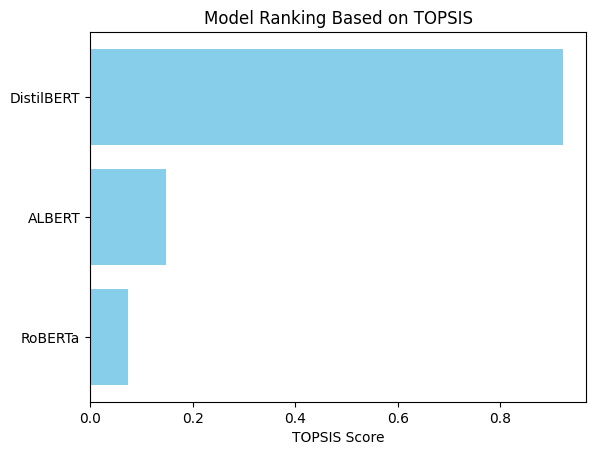

In [11]:
if __name__ == "__main__":
    dataset = load_dataset("ag_news", split="test")
    texts = dataset["text"]
    labels = dataset["label"]

    models = load_models()
    weights = [0.4, 0.4, 0.1, 0.1]  # Importance of metrics
    criteria = [1, 1, 0, 0]  # Higher is better for accuracy & F1, lower is better for inference time & size

    df = evaluate_models(models, texts, labels, weights, criteria)
    print(df)
    plot_results(df.index, df["TOPSIS Score"])
